In [ ]:
!pip install tensorflow==2.15.0
!pip install tensorflow-probability==0.23.0


In [ ]:
import shutil
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

from google.colab import drive
'''
# Mount google drive in colab
drive.mount('/content/gdrive/', force_remount=True)

# Unzip dataset file in colab
kaggle_dir = '/content/gdrive/MyDrive/Kaggle/'

filename = 'isic-2024-challenge.zip'

with zipfile.ZipFile(f'{kaggle_dir}/{filename}', 'r') as zp:
  zp.extractall('Kaggle-ISIC-Challenge/dataset/')
  '''

"\n# Mount google drive in colab\ndrive.mount('/content/gdrive/', force_remount=True)\n\n# Unzip dataset file in colab\nkaggle_dir = '/content/gdrive/MyDrive/Kaggle/'\n\nfilename = 'isic-2024-challenge.zip'\n\nwith zipfile.ZipFile(f'{kaggle_dir}/{filename}', 'r') as zp:\n  zp.extractall('Kaggle-ISIC-Challenge/dataset/')\n  "

In [ ]:
directory = 'Kaggle-ISIC-Challenge/dataset'
df_train = pd.read_csv(f"{directory}/train-metadata.csv")
df_test = pd.read_csv(f"{directory}/test-metadata.csv")

#train_target = df_train['target']
#test_target = df_test['target']

def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2)
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["area_to_perimeter_ratio"] = df["tbp_lv_areaMM2"] / df["tbp_lv_perimeterMM"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["symmetry_border_consistency2"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"] / (df["tbp_lv_symm_2axis"] + df["tbp_lv_norm_border"])
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    df["color_consistency2"] = df["tbp_lv_stdL"] * df["tbp_lv_Lext"] / (df["tbp_lv_stdL"] + df["tbp_lv_Lext"])

    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
    df["age_size_symmetry_index2"] = df["age_approx"] * df["tbp_lv_areaMM2"] * df["tbp_lv_symm_2axis"]
    # Until here.

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio","area_to_perimeter_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "symmetry_border_consistency2", "color_consistency","color_consistency2",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index",
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",

        "color_variance_ratio", "border_color_interaction", "size_color_contrast_ratio",
        "age_normalized_nevi_confidence", "color_asymmetry_index", "3d_volume_approximation",
        "color_range", "shape_color_consistency", "border_length_ratio", "age_size_symmetry_index","age_size_symmetry_index2",
    ]
    new_cat_cols = ["combined_anatomical_site"]

    #生成zscore特征
    floating_df = df.loc[:,df.dtypes == np.floating]
    mean = floating_df.mean()
    std = floating_df.std()
    zscore = (floating_df - mean)/std
    zscore = zscore[[x for x in zscore.columns if x in new_num_cols]]
    zscore.columns = [f"zscore_{col}" for col in zscore.columns]
    df = pd.concat([df,zscore],axis = 1)
    new_num_cols.extend(zscore.columns)

    #floating_df = df.loc[:,df.dtypes == np.floating]
    #mean = floating_df.mean()
    #std = floating_df.std()
    #zscore = (floating_df - mean)/std
    #zscore.columns = [f"zscore_{col}" for col in zscore.columns]
    #try:
    #    zscore.drop(['zscore_mel_thick_mm', 'zscore_tbp_lv_dnn_lesion_confidence'],axis = 1,inplace = True)
    #except:
    #    continue
    #df = pd.concat([df,zscore],axis = 1)
    #new_num_cols.extend(zscore.columns)

    return df, new_num_cols, new_cat_cols

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean',
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
]

df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_test [num_cols] = df_test [num_cols].fillna(df_train[num_cols].median())

df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _                        = feature_engineering(df_test.copy())

num_cols += new_num_cols

# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

df_train = df_train[train_cols + ['isic_id', 'target']]


<ipython-input-5-1031480e2983>:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f"{directory}/train-metadata.csv")


In [ ]:
def one_hot_encode_categorical_cols(df, categorical_cols):
  """Converts specified categorical columns in a DataFrame to one-hot encoding.

  Args:
    df: The Pandas DataFrame.
    categorical_cols: A list of column names to be one-hot encoded.

  Returns:
    A DataFrame with the specified categorical columns one-hot encoded.
  """
  # Create a copy of the DataFrame to avoid modifying the original
  encoded_df = df.copy()

  # Apply one-hot encoding to each categorical column
  for col in categorical_cols:
    # Get one-hot encoded columns for the current categorical column
    if col not in encoded_df.columns:
      print(f'{col} not found')
      continue
    one_hot_encoded = pd.get_dummies(encoded_df[col], prefix=col)

    # Drop the original categorical column
    encoded_df = encoded_df.drop(col, axis=1)

    # Concatenate the one-hot encoded columns with the DataFrame
    encoded_df = pd.concat([encoded_df, one_hot_encoded], axis=1)

  return encoded_df
cat_cols_extra = ['sex_female', 'sex_male', 'tbp_tile_type_3D: XP', 'tbp_tile_type_3D: white', 'tbp_lv_location_Head & Neck', 'tbp_lv_location_Left Arm', 'tbp_lv_location_Left Arm - Lower', 'tbp_lv_location_Left Arm - Upper', 'tbp_lv_location_Left Leg', 'tbp_lv_location_Left Leg - Lower', 'tbp_lv_location_Left Leg - Upper', 'tbp_lv_location_Right Arm', 'tbp_lv_location_Right Arm - Lower', 'tbp_lv_location_Right Arm - Upper', 'tbp_lv_location_Right Leg', 'tbp_lv_location_Right Leg - Lower', 'tbp_lv_location_Right Leg - Upper', 'tbp_lv_location_Torso Back', 'tbp_lv_location_Torso Back Bottom Third', 'tbp_lv_location_Torso Back Middle Third', 'tbp_lv_location_Torso Back Top Third', 'tbp_lv_location_Torso Front', 'tbp_lv_location_Torso Front Bottom Half', 'tbp_lv_location_Torso Front Top Half', 'tbp_lv_location_Unknown', 'tbp_lv_location_simple_Head & Neck', 'tbp_lv_location_simple_Left Arm', 'tbp_lv_location_simple_Left Leg', 'tbp_lv_location_simple_Right Arm', 'tbp_lv_location_simple_Right Leg', 'tbp_lv_location_simple_Torso Back', 'tbp_lv_location_simple_Torso Front', 'tbp_lv_location_simple_Unknown', 'combined_anatomical_site_anterior torso_Torso Front', 'combined_anatomical_site_anterior torso_Torso Front Bottom Half', 'combined_anatomical_site_anterior torso_Torso Front Top Half', 'combined_anatomical_site_head/neck_Head & Neck', 'combined_anatomical_site_lower extremity_Left Leg', 'combined_anatomical_site_lower extremity_Left Leg - Lower', 'combined_anatomical_site_lower extremity_Left Leg - Upper', 'combined_anatomical_site_lower extremity_Right Leg', 'combined_anatomical_site_lower extremity_Right Leg - Lower', 'combined_anatomical_site_lower extremity_Right Leg - Upper', 'combined_anatomical_site_posterior torso_Torso Back', 'combined_anatomical_site_posterior torso_Torso Back Bottom Third', 'combined_anatomical_site_posterior torso_Torso Back Middle Third', 'combined_anatomical_site_posterior torso_Torso Back Top Third', 'combined_anatomical_site_upper extremity_Left Arm', 'combined_anatomical_site_upper extremity_Left Arm - Lower', 'combined_anatomical_site_upper extremity_Left Arm - Upper', 'combined_anatomical_site_upper extremity_Right Arm', 'combined_anatomical_site_upper extremity_Right Arm - Lower', 'combined_anatomical_site_upper extremity_Right Arm - Upper']
#df_test = one_hot_encode_categorical_cols(df_test, cat_cols+cat_cols_extra)
df_train = one_hot_encode_categorical_cols(df_train, cat_cols + cat_cols_extra)

In [ ]:
'''
train_csv = f'Kaggle-ISIC-Challenge/dataset/train-metadata.csv'
train_df = pd.read_csv(train_csv)

columns = train_df.columns

print(f'Columns: {columns}')

# TODO: Add all variables
# Continous columns- starting analysis on a subset of columns for now
continous = ['age_approx',
 'tbp_lv_C',
 'clin_size_long_diam_mm',
 'tbp_lv_A',
 'tbp_lv_Aext',
 'tbp_lv_B',
 'tbp_lv_Bext',
 'tbp_lv_C',
 'tbp_lv_Cext',
 'tbp_lv_H',
 'tbp_lv_Hext',
'tbp_lv_L',
'tbp_lv_Lext',
'tbp_lv_areaMM2',
'tbp_lv_area_perim_ratio',
'tbp_lv_color_std_mean',
'tbp_lv_deltaA',
'tbp_lv_deltaB',
'tbp_lv_deltaL',
'tbp_lv_deltaLB',
'tbp_lv_deltaLBnorm',
'tbp_lv_eccentricity',]

# Categorical columns
categorical = ['anatom_site_general',
 'tbp_tile_type',
 'image_type',
 'tbp_lv_location',
 'tbp_lv_location_simple']

continous_vars = train_df[continous]
categorical_vars = train_df[categorical]

continous_vars['target'] = train_df['target']
continous_vars['id'] = train_df['isic_id']
'''

"\ntrain_csv = f'Kaggle-ISIC-Challenge/dataset/train-metadata.csv'\ntrain_df = pd.read_csv(train_csv)\n\ncolumns = train_df.columns\n\nprint(f'Columns: {columns}')\n\n# TODO: Add all variables\n# Continous columns- starting analysis on a subset of columns for now\ncontinous = ['age_approx',\n 'tbp_lv_C',\n 'clin_size_long_diam_mm',\n 'tbp_lv_A',\n 'tbp_lv_Aext',\n 'tbp_lv_B',\n 'tbp_lv_Bext',\n 'tbp_lv_C',\n 'tbp_lv_Cext',\n 'tbp_lv_H',\n 'tbp_lv_Hext',\n'tbp_lv_L',\n'tbp_lv_Lext',\n'tbp_lv_areaMM2',\n'tbp_lv_area_perim_ratio',\n'tbp_lv_color_std_mean',\n'tbp_lv_deltaA',\n'tbp_lv_deltaB',\n'tbp_lv_deltaL',\n'tbp_lv_deltaLB',\n'tbp_lv_deltaLBnorm',\n'tbp_lv_eccentricity',]\n\n# Categorical columns\ncategorical = ['anatom_site_general',\n 'tbp_tile_type',\n 'image_type',\n 'tbp_lv_location',\n 'tbp_lv_location_simple']\n\ncontinous_vars = train_df[continous]\ncategorical_vars = train_df[categorical]\n\ncontinous_vars['target'] = train_df['target']\ncontinous_vars['id'] = train_df['isic_i

In [ ]:
'''
from sklearn.model_selection import train_test_split

train_df = continous_vars.copy()
# Normalize columns
for col in continous:
  train_df[col] = (train_df[col] - train_df[col].min()) / (train_df[col].max() - train_df[col].min())

# Get NaN value counts age_approx : 2798
#nan_counts = continous_vars.isna().sum()
mean_age = train_df['age_approx'].mean()
train_df['age_approx'].fillna(mean_age, inplace=True)

# Split dataset
train, test = train_test_split(train_df, test_size=0.2, random_state=42)

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
'''

"\nfrom sklearn.model_selection import train_test_split\n\ntrain_df = continous_vars.copy()\n# Normalize columns\nfor col in continous:\n  train_df[col] = (train_df[col] - train_df[col].min()) / (train_df[col].max() - train_df[col].min())\n\n# Get NaN value counts age_approx : 2798\n#nan_counts = continous_vars.isna().sum()\nmean_age = train_df['age_approx'].mean()\ntrain_df['age_approx'].fillna(mean_age, inplace=True)\n\n# Split dataset\ntrain, test = train_test_split(train_df, test_size=0.2, random_state=42)\n\nprint(f'Train shape: {train.shape}')\nprint(f'Test shape: {test.shape}')\n"

In [ ]:
from sklearn.model_selection import train_test_split
'''
train_df = continous_vars.copy()
# Normalize columns
for col in continous:
  train_df[col] = (train_df[col] - train_df[col].min()) / (train_df[col].max() - train_df[col].min())

# Get NaN value counts age_approx : 2798
#nan_counts = continous_vars.isna().sum()
mean_age = train_df['age_approx'].mean()
train_df['age_approx'].fillna(mean_age, inplace=True)
'''
# Split dataset
train, test = train_test_split(df_train, test_size=0.25, random_state=42)

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (300794, 222)
Test shape: (100265, 222)


In [ ]:
print('Initial:', train['target'].value_counts())

def undersample_data(df, divisor = 25):
  # Undersample class 0 by 1/5 times
  cls_indices = [idx for idx, cls in enumerate(df['target'].values) if cls == 0]
  cls_1 = [idx for idx, cls in enumerate(df['target'].values) if cls == 1]
  to_keep = len(cls_indices)//divisor
  np.random.shuffle(cls_indices)
  indices_to_keep = cls_indices[:to_keep]
  all_indices = indices_to_keep + cls_1

  np.random.shuffle(all_indices)
  df = df.iloc[all_indices]
  return df

train = undersample_data(train)
test = undersample_data(test)

print('Final', train['target'].value_counts())

Initial: target
0    300491
1       303
Name: count, dtype: int64
Final target
0    12019
1      303
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from PIL import Image
class DataGenerator_v2(tf.keras.utils.Sequence):
  def __init__(self, image_ids, df, labels, batch_size=16):

    self.image_ids = image_ids
    self.df = df
    self.labels = labels
    self.batch_size = batch_size

    self.IMAGE_SIZE = 224
    self.image_dir = 'Kaggle-ISIC-Challenge/dataset/train-image/image'

  def __len__(self):
    return int(np.ceil(len(self.df) / self.batch_size))

  def __getitem__(self, index):

    batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

    # Image features
    batch_ids = self.image_ids[index * self.batch_size : (index + 1) * self.batch_size]

    batch_images = []
    image_features = []
    for id in batch_ids:
      q = Image.open(f'{self.image_dir}/{id}.jpg')
      q = np.array(q.resize((self.IMAGE_SIZE, self.IMAGE_SIZE)))
      batch_images.append(q)

    length = len(batch_images)
    numerical_features = batch_df.to_numpy()

    # Batch labels
    batch_y = self.labels[index*self.batch_size : (index+1)*self.batch_size]

    return np.array(batch_images).reshape(length, 224, 224, 3), np.asarray(batch_y)

In [ ]:
import tensorflow as tf
from PIL import Image
class DataGenerator_v3(tf.keras.utils.Sequence):
  def __init__(self, image_ids, df, labels, batch_size=16):

    self.image_ids = image_ids
    self.df = df
    self.labels = labels
    self.batch_size = batch_size

    self.IMAGE_SIZE = 224
    self.image_dir = 'Kaggle-ISIC-Challenge/dataset/train-image/image'

  def __len__(self):
    return int(np.ceil(len(self.df) / self.batch_size))

  def __getitem__(self, index):

    batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

    # Image features
    batch_ids = self.image_ids[index * self.batch_size : (index + 1) * self.batch_size]

    batch_images = []
    image_features = []
    for id in batch_ids:
      q = Image.open(f'{self.image_dir}/{id}.jpg')
      q = np.array(q.resize((self.IMAGE_SIZE, self.IMAGE_SIZE)))
      batch_images.append(q)

    length = len(batch_images)
    numerical_features = batch_df.to_numpy()

    # Batch labels
    batch_y = self.labels[index*self.batch_size : (index+1)*self.batch_size]

    return [tf.convert_to_tensor(np.array(batch_images).reshape(length, 224, 224, 3), dtype = 'float32'), tf.convert_to_tensor(np.array(numerical_features), dtype = 'float32')], np.asarray(batch_y)

In [ ]:
dtype= 'float32'
train_labels = train['target'].values
train_image_ids = train['isic_id'].values
train_input = train.drop(['target', 'isic_id'], axis = 1)

train_data_gen = DataGenerator_v3(train_image_ids, train_input, train_labels, 8)

test_labels = test['target'].values
test_image_ids = test['isic_id'].values
test_input = test.drop(['target', 'isic_id'], axis = 1)

val_data_gen = DataGenerator_v3(test_image_ids, test_input, test_labels,  8)

In [ ]:
x, y = train_data_gen.__getitem__(0)
print(x[0].shape)
print(x[1].shape)
print(y.shape)

(8, 224, 224, 3)
(8, 220)
(8,)


Shape of X : (8, 224, 224, 3)
Shape of y: (8,) int64
(8, 224, 224, 3)


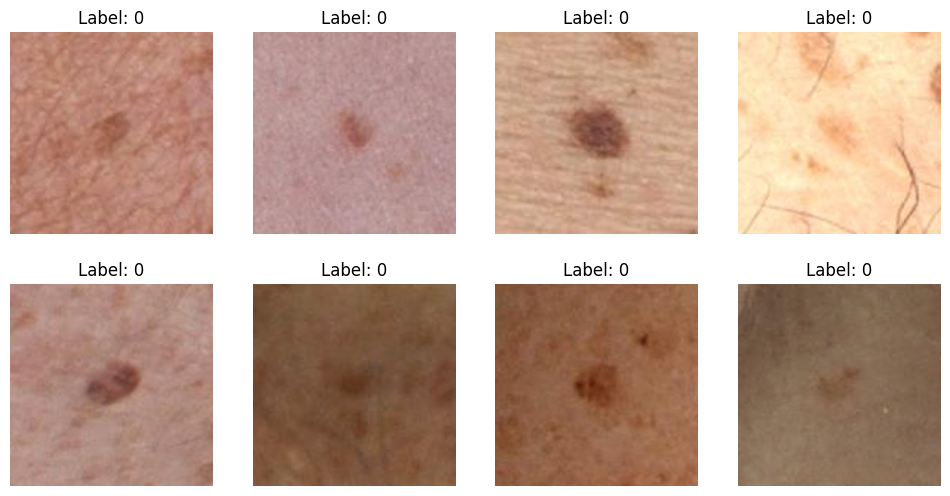

In [ ]:
#check Train Dataloader for each batch
for x, y in val_data_gen:
  x1 = x[0]
  print(f"Shape of X : {x1.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  print(x1.shape)
  fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows, 4 columns
  for i in range(x1.shape[0]):
      row = i // 4
      col = i % 4
      axes[row, col].imshow(x1[i])
      axes[row, col].axis('off')  # Hide axes
      axes[row, col].set_title(f'Label: {y[i]}')
  break
  plt.show()

In [ ]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

examples = int(train.shape[0])

kl_divergence = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(tf.shape(q.sample())[0], tf.float32))

divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / examples

# For Reparameterization Layers
def custom_normal_prior(dtype, shape, name, trainable, add_variable_fn):
    distribution = tfd.Normal(loc = 0.1 * tf.ones(shape, dtype),
                              scale = 1.5 * tf.ones(shape, dtype))
    batch_ndims = tf.size(distribution.batch_shape_tensor())

    distribution = tfd.Independent(distribution,
                                   reinterpreted_batch_ndims = batch_ndims)
    return distribution

def laplace_prior(dtype, shape, name, trainable, add_variable_fn):
    distribution = tfd.Laplace(loc = tf.zeros(shape, dtype),
                               scale = tf.ones(shape, dtype))
    batch_ndims = tf.size(distribution.batch_shape_tensor())

    distribution = tfd.Independent(distribution,
                                   reinterpreted_batch_ndims = batch_ndims)
    return distribution


In [ ]:
#import tf_keras
bayesian_cnn = tf.keras.Sequential([
    tfp.layers.Convolution2DReparameterization(
        16, kernel_size=5, padding='SAME', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D([2, 2]),

    tfp.layers.Convolution2DReparameterization(
        32, kernel_size=5, padding='SAME', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2),

    tfp.layers.Convolution2DReparameterization(
        64, kernel_size=5, padding='SAME', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2),

    tfp.layers.Convolution2DReparameterization(
        128, kernel_size=5, padding='SAME', activation=tf.nn.relu),
    tf.keras.layers.GlobalMaxPooling2D(),

    tfpl.DenseReparameterization(
        units = 1, activation = 'sigmoid',
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,

        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),

        kernel_divergence_fn = divergence_fn,
        bias_divergence_fn = divergence_fn),

    tfp.layers.DistributionLambda(lambda t: tfd.Bernoulli(logits = t))
])

bayesian_cnn.build(x[0].shape)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
from sys import stdlib_module_names
# Setting up a bayesian neural network

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

# A normal distribution (mean = 0, sd = 1) as prior for kernel weights
def prior(kernel_size: int, bias_size : int, dtype):
  '''
  To apply baye's theorem we start with a prior distribution which represents our prior beliefs about the weight distribution
  Prior distribution is not trainable
  '''
  n = kernel_size + bias_size
  return lambda t: tfd.Independent(tfd.Normal(loc = tf.zeros(n, dtype = dtype), scale = 1.), reinterpreted_batch_ndims = 1)

def random_gaussian_initializer(shape, dtype):
  '''
  Initialize random normal distributions for out surrogate posterior

  shape: number of (means + standard deviations)
  '''
  n = int(shape/2)
  loc_norm = tf.random_normal_initializer(mean = 0., stddev = 1.)
  loc = tf.Variable(initial_value = loc_norm(shape = (n,), dtype=dtype))

  scale_norm = tf.random_normal_initializer(mean = 2., stddev = 1.)
  scale = tf.Variable(initial_value = scale_norm(shape = (n,), dtype=dtype))

  return tf.concat([loc, scale], 0)


def posterior_mean_field(kernel_size: int, bias_size: int, dtype):
  '''
  Posterior distribution is a keras sequential model of two layers
  1. Layer 1 is made of 2*n trainable variables (representing mean and standard deviation for every kernel)
  2. Layer 2 is a tf probability distribution (normal distribution in this case) which is initalized using variables
  from the first layer

  This distribution represent our final beliefs for the weights of neural network
  '''
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))

  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype = dtype,
                    initializer = lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable = True),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc = t[..., :n], scale = 1e-5 + tf.nn.softplus(c + t[..., n:])), reinterpreted_batch_ndims = 1))
      ])

In [ ]:
from keras.layers import Input, concatenate
from keras.models import Model

#import tf_keras
image_model_in = Input(x[0].shape[1:])
image_model = tfp.layers.Convolution2DReparameterization(16, kernel_size=5, padding='SAME', activation=tf.nn.relu)(image_model_in)
image_model = tf.keras.layers.MaxPooling2D([2, 2])(image_model)
image_model = tfp.layers.Convolution2DReparameterization(32, kernel_size=5, padding='SAME', activation=tf.nn.relu)(image_model)
image_model = tf.keras.layers.MaxPooling2D(2)(image_model)
image_model = tfp.layers.Convolution2DReparameterization(64, kernel_size=5, padding='SAME', activation=tf.nn.relu)(image_model)
image_model = tf.keras.layers.MaxPooling2D(2)(image_model)
image_model = tfp.layers.Convolution2DReparameterization(128, kernel_size=5, padding='SAME', activation=tf.nn.relu)(image_model)
image_model = tf.keras.layers.GlobalMaxPooling2D()(image_model)
image_model = tfpl.DenseReparameterization(units = 16, activation = tf.nn.relu,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,

        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),

        kernel_divergence_fn = divergence_fn,
        bias_divergence_fn = divergence_fn)(image_model)

numerical_model_in = Input(x[1].shape[1:])
numerical_model = tfpl.DenseVariational(units = 512, make_posterior_fn=posterior_mean_field, make_prior_fn=prior, kl_weight=1/examples, activation = 'gelu')(numerical_model_in)
numerical_model = tfpl.DenseVariational(units = 128, make_posterior_fn=posterior_mean_field, make_prior_fn=prior, kl_weight=1/examples, activation = 'gelu')(numerical_model)
numerical_model = tf.keras.layers.Dense(units = 16, activation = 'relu')(numerical_model)

concat = concatenate([image_model, numerical_model])
ensemble_model_in = tfpl.DenseVariational(units = 128, make_posterior_fn=posterior_mean_field, make_prior_fn=prior, kl_weight=1/examples, activation = 'gelu')(concat)
ensemble_model_in = tfpl.DenseVariational(units = 32, make_posterior_fn=posterior_mean_field, make_prior_fn=prior, kl_weight=1/examples, activation = 'gelu')(ensemble_model_in)
ensemble_model_out = tfpl.DenseVariational(units = 1, make_posterior_fn=posterior_mean_field, make_prior_fn=prior, kl_weight=1/examples, activation = 'sigmoid')(ensemble_model_in)
ensemble_model_out = tfpl.DistributionLambda(lambda t: tfd.Bernoulli(logits = t))(ensemble_model_out)

ensemble_model = Model(inputs = [image_model_in, numerical_model_in], outputs = ensemble_model_out)

<ipython-input-15-8437ec24ef7a>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(shape/2)


In [ ]:
x[1].shape

(8, 220)

In [ ]:
def nll(y_true, y_pred):
  nll = -y_pred.log_prob(y_true)
  return nll

'''
bayesian_cnn.compile(loss=nll,
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

bayesian_cnn.fit(train_data_gen, validation_data=val_data_gen, epochs = 50, steps_per_epoch = 250)
'''

ensemble_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002), loss = nll, metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.BinaryCrossentropy()])
ensemble_model.fit(train_data_gen, validation_data = val_data_gen, epochs = 50, steps_per_epoch = 150)

Epoch 1/50
150/150 [==============================] - 56s 346ms/step - loss: nan - binary_accuracy: 0.9692 - binary_crossentropy: 0.4756 - val_loss: nan - val_binary_accuracy: 0.9780 - val_binary_crossentropy: 0.3388
Epoch 2/50
150/150 [==============================] - 52s 346ms/step - loss: nan - binary_accuracy: 0.9816 - binary_crossentropy: 0.2842 - val_loss: nan - val_binary_accuracy: 0.9780 - val_binary_crossentropy: 0.3388
Epoch 3/50
150/150 [==============================] - 57s 378ms/step - loss: nan - binary_accuracy: 0.9742 - binary_crossentropy: 0.3985 - val_loss: nan - val_binary_accuracy: 0.9780 - val_binary_crossentropy: 0.3388
Epoch 4/50
150/150 [==============================] - 51s 340ms/step - loss: nan - binary_accuracy: 0.9707 - binary_crossentropy: 0.4522 - val_loss: nan - val_binary_accuracy: 0.9780 - val_binary_crossentropy: 0.3388
Epoch 5/50
150/150 [==============================] - 51s 341ms/step - loss: nan - binary_accuracy: 0.9717 - binary_crossentropy: 0.